### <p style="text-align: right;"> Alexis Guevara

## Real World Application - Electrocardiogram (ECG) Signals



==== Modeling dECG/dt ====

# === Lasso-selected coefficients ===
('ECG(t-0)', -92.577018)
('ECG(t-1)', 112.356449)
('ECG(t-2)', -20.200384)
('ECG(t-3)', -0.979044)
('ECG(t-5)', 2.426597)
('ECG(t-7)', -4.029364)
('ECG(t-10)', 8.602307)
('ECG(t-11)', -2.672113)

# === OLS-refitted coefficients ===
('ECG(t-0)', -96.873843)
('ECG(t-1)', 132.766702)
('ECG(t-2)', -53.448087)
('ECG(t-3)', 17.403921)


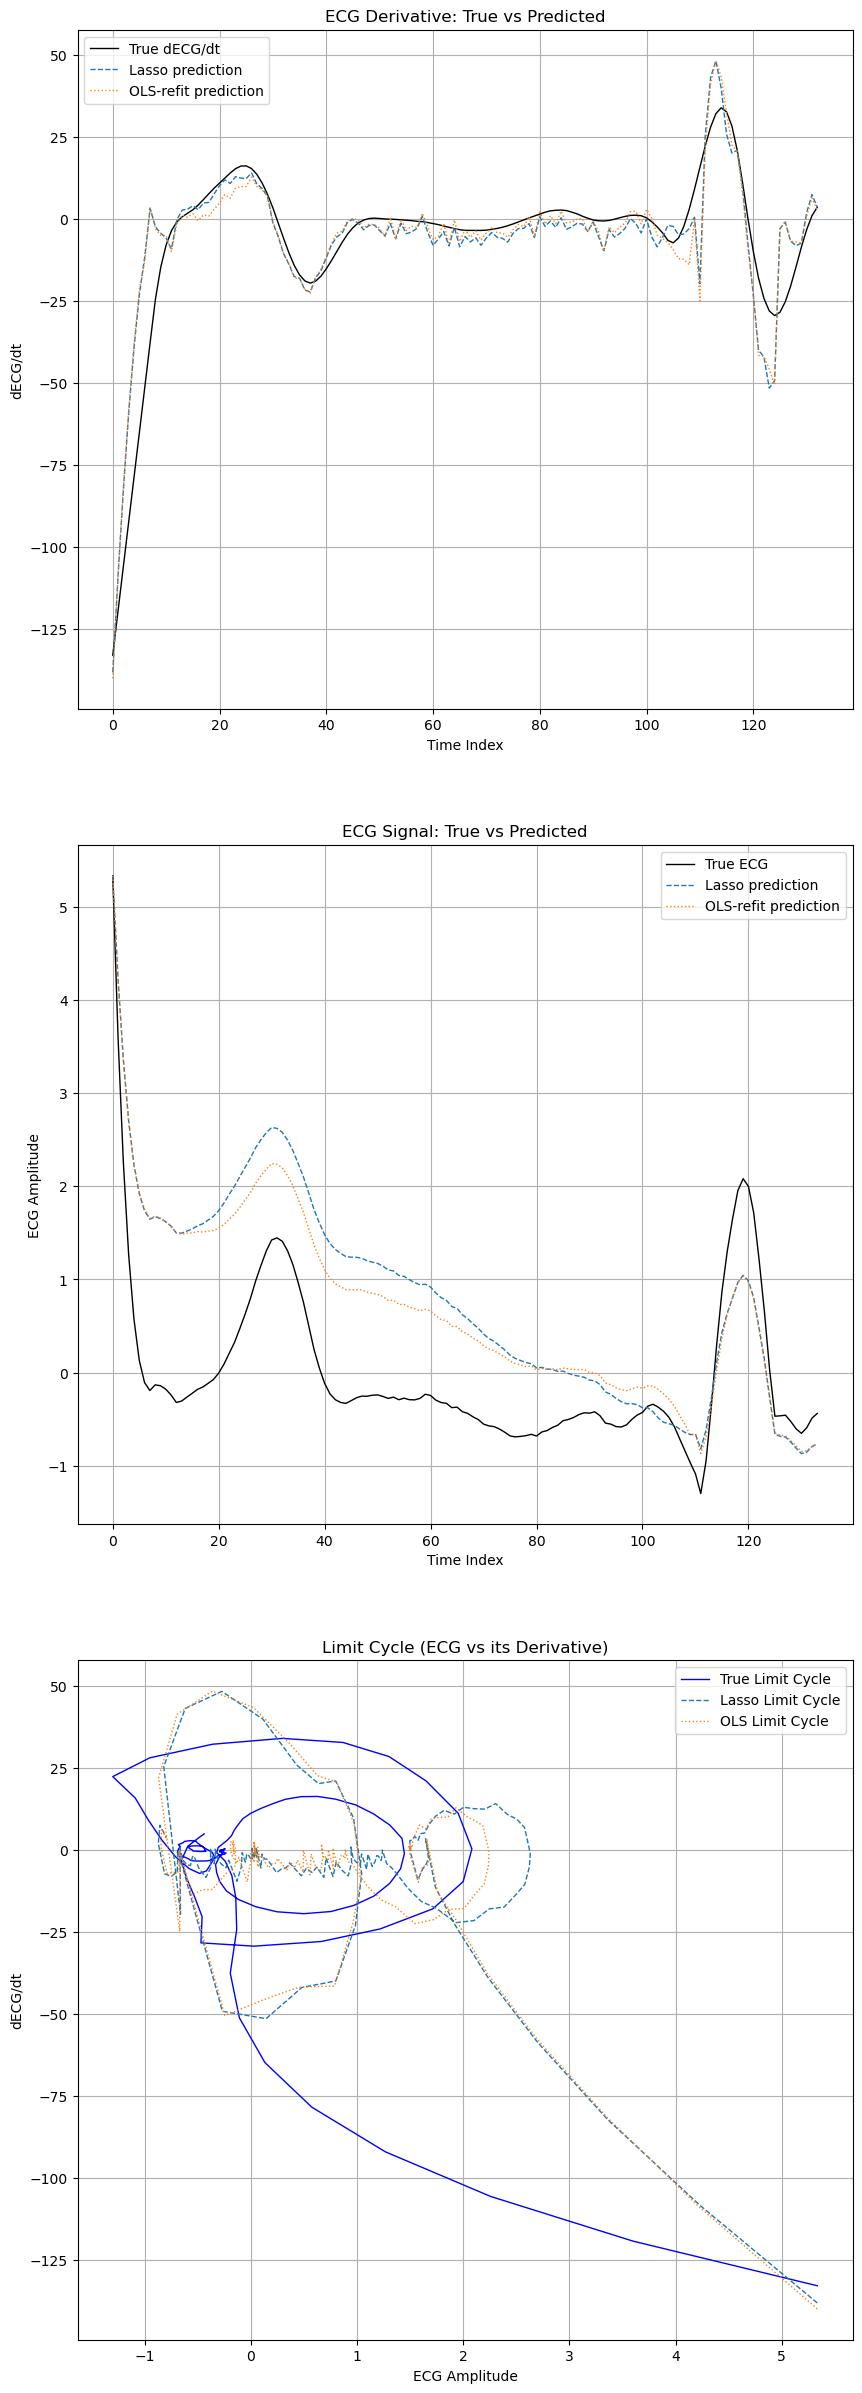

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from itertools import combinations_with_replacement

# ==============================================
# CONFIGURATION (ADJUST THESE AS NEEDED)
# ==============================================
EMBEDDING_DIM = 12   # Reduced embedding dimension for short signals
POLY_DEGREE = 1      # Polynomial degree for features
TAU = 1              # Fixed small delay for short signals
FS = 125             # Matches dataset sampling frequency
THRESHOLD = 1e-6     # Coefficient threshold for feature selection
SMOOTH_WINDOW = 15   # Window length for SavGol filter (must be odd)
SMOOTH_ORDER = 3    # Polynomial order for SavGol filter
# ==============================================

# 1. Load and preprocess ECG data
def load_ecg_data(filepath):
    """Load ECG data from CSV file"""
    df = pd.read_csv(filepath)
    ecg_signal = df.iloc[0, :-1].values  # Exclude the class label
    ecg_signal = ecg_signal[ecg_signal != 0]  # Remove padding zeros
    
    if len(ecg_signal) < 100:  # If too much was padded
        ecg_signal = df.iloc[0, :-1].values  # Use original with zeros
    
    # Normalize
    ecg_clean = StandardScaler().fit_transform(ecg_signal.reshape(-1, 1)).flatten()
    
    # Apply smoothing filter to the raw ECG signal
    window = min(SMOOTH_WINDOW, len(ecg_clean) - 1) 
    if window % 2 == 0:  # Ensure window length is odd
        window -= 1
    if window > SMOOTH_ORDER:
        ecg_clean = savgol_filter(ecg_clean, window_length=window, polyorder=SMOOTH_ORDER)
    
    return ecg_clean

# 2. Compute ECG derivatives
def calculate_ecg_derivative(signal, fs):
    """Calculate ECG derivative using Savitzky-Golay filter"""
    dt = 1/fs
    window = min(15, len(signal) - 1 if len(signal) % 2 == 0 else min(15, len(signal)))
    if window % 2 == 0:  # Ensure window length is odd
        window -= 1
    return savgol_filter(signal, window_length=window, polyorder=2, deriv=1, delta=dt)

# 3. Create time-delay embedding
def create_embedding(signal, tau, dim):
    """Create time-delay embedding for ECG signal"""
    N = len(signal) - (dim - 1) * tau
    if N <= 10:
        raise ValueError(f"Signal too short ({len(signal)} samples) for embedding")
    emb = np.zeros((N, dim))
    for i in range(dim):
        emb[:, i] = signal[i*tau : i*tau + N]
    return emb

# 4. Build polynomial feature matrix
def generate_feature_names(dim, tau, degree):
    """Generate names for ECG features"""
    delays = [f"ECG(t-{i*tau})" for i in range(dim)]
    names = ['1']  # For bias term
    for d in range(1, degree+1):
        for comb in combinations_with_replacement(delays, d):
            names.append(" × ".join(comb))
    return names

# 5. Modeling function for ECG derivatives
def model_derivative(Theta, target, feature_names, threshold, derivative_name):
    print(f"\n\n==== Modeling {derivative_name} ====")
    
    # Lasso regression for sparse model
    lasso = Lasso(alpha=0.01, max_iter=10000).fit(Theta, target)

    # Display Lasso-selected features
    print("\n# === Lasso-selected coefficients ===")
    selected_idx = []
    for idx, coef in enumerate(lasso.coef_):
        if abs(coef) > threshold:
            print(f"('{feature_names[idx]}', {coef:.6f})")
            selected_idx.append(idx)
    
    # OLS with forward selection
    def fit_ols_select(X, y, idxs):
        if len(idxs) <= 1:
            model = LinearRegression().fit(X[:, idxs], y)
            return model, np.array(idxs)
        sfs = SequentialFeatureSelector(
            LinearRegression(), direction='forward', scoring='r2', cv=5
        )
        sfs.fit(X[:, idxs], y)
        final_idxs = np.array(idxs)[sfs.get_support()]
        model = LinearRegression().fit(X[:, final_idxs], y)
        return model, final_idxs
    
    ols_model, final_idx = fit_ols_select(Theta, target, selected_idx)

    # Display OLS coefficients
    print("\n# === OLS-refitted coefficients ===")
    for i, idx in enumerate(final_idx):
        print(f"('{feature_names[idx]}', {ols_model.coef_[i]:.6f})")
    
    return lasso, ols_model, final_idx

# 6. State prediction function
def predict_states(Theta, model, selected_idx, x0, dt):
    """Predict ECG states using learned model"""
    N = len(Theta)
    x_pred = np.zeros(N+1)
    x_pred[0] = x0
    x_pred[1] = Theta[0,1]  # First delay coordinate
    
    for i in range(1, N):
        if isinstance(model, LinearRegression):
            dxdt = model.predict(Theta[i-1:i, selected_idx])[0]
        else:
            dxdt = model.predict(Theta[i-1:i])[0]
        x_pred[i+1] = x_pred[i] + dxdt * dt
    
    return x_pred[1:]

# Main analysis pipeline
if __name__ == "__main__":
    try:
        # 1. Load ECG data
        ecg = load_ecg_data("ptbdb_abnormal.csv")
        
        # 2. Compute derivatives
        decgdt = calculate_ecg_derivative(ecg, FS)
        
        # 3. Create embedding
        embedding = create_embedding(ecg, TAU, EMBEDDING_DIM)
        decgdt_target = decgdt[:len(embedding)]
        
        # 4. Build feature matrix
        poly = PolynomialFeatures(degree=POLY_DEGREE, include_bias=True)
        Theta = poly.fit_transform(embedding)
        feature_names = generate_feature_names(EMBEDDING_DIM, TAU, POLY_DEGREE)
        
        # 5. Model ECG dynamics
        lasso_model, ols_model, selected_idx = model_derivative(
            Theta[:-1], decgdt_target[:-1], feature_names, THRESHOLD, 'dECG/dt')
        
        # 6. Compare predictions
        lasso_pred = lasso_model.predict(Theta[:-1])
        ols_pred = ols_model.predict(Theta[:-1, selected_idx])
        
        # 7. State predictions
        ecg_pred_lasso = predict_states(Theta, lasso_model, selected_idx, ecg[0], 1/FS)
        ecg_pred_ols = predict_states(Theta, ols_model, selected_idx, ecg[0], 1/FS)
        
        # 8. Create plots
        plt.figure(figsize=(10, 30))
        
        # Derivative comparison
        plt.subplot(3, 1, 1)
        plt.plot(decgdt_target[:-1], label='True dECG/dt', color='black', lw=1)
        plt.plot(lasso_pred, label='Lasso prediction', linestyle='--', lw=1)
        plt.plot(ols_pred, label='OLS-refit prediction', linestyle=':', lw=1)
        plt.xlabel('Time Index')
        plt.ylabel('dECG/dt')
        plt.title('ECG Derivative: True vs Predicted')
        plt.legend()
        plt.grid()
        
        # ECG signal comparison
        plt.subplot(3, 1, 2)
        plt.plot(ecg[:len(embedding)], label='True ECG', color='black', lw=1)
        plt.plot(ecg_pred_lasso, label='Lasso prediction', linestyle='--', lw=1)
        plt.plot(ecg_pred_ols, label='OLS-refit prediction', linestyle=':', lw=1)
        plt.xlabel('Time Index')
        plt.ylabel('ECG Amplitude')
        plt.title('ECG Signal: True vs Predicted')
        plt.legend()
        plt.grid()

        # Limit cycle plot (ECG vs its derivative)
        plt.subplot(3, 1, 3)
        plt.plot(ecg[:len(decgdt_target)], decgdt_target, 
                 label='True Limit Cycle', color='blue', lw=1)
        plt.plot(ecg_pred_lasso[:len(lasso_pred)], lasso_pred, 
                 label='Lasso Limit Cycle', linestyle='--', lw=1)
        plt.plot(ecg_pred_ols[:len(ols_pred)], ols_pred, 
                 label='OLS Limit Cycle', linestyle=':', lw=1)
        plt.xlabel('ECG Amplitude')
        plt.ylabel('dECG/dt')
        plt.title('Limit Cycle (ECG vs its Derivative)')
        plt.legend()
        plt.grid()
        
    except Exception as e:
        print(f"\nError encountered")